# BiGAN : Dataframe with weather parameter and randomly allocated building parameters from 2008 to 2017

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import weibull_min
from scipy.stats import norm
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from ctgan import CTGAN

So my orginal data has only the realtime weather data(temperature,humidity,solar radiation) , however home parameters are randomly generated following the statistics of the houses in sydney, after that we randomly allocate the values for power consumption too.

In [2]:
file_path = r"E:\desktop backie\ftp sydney\fin task 2\fin_ftp_task2.xlsx"
columns_to_keep = ['Date', 'MinTemp', 'MaxTemp','Humidity9am', 'Humidity3pm', 'Solar Radiation' ]
df = pd.read_excel(file_path, usecols=columns_to_keep)
df['Avg_Humid(%)']=(df['Humidity3pm']+df['Humidity9am'])/2
df['Avg_Temp(C)']=(df['MaxTemp']+df['MinTemp'])/2
df.drop(['MinTemp', 'MaxTemp', 'Humidity9am' ,'Humidity3pm'], axis=1, inplace=True)
df

,Date,Solar Radiation,Avg_Humid(%),Avg_Temp(C)
0,2008-02-01,75.231481,88.0,20.95
1,2008-02-02,192.129630,78.0,22.55
2,2008-02-03,107.638889,87.0,23.05
3,2008-02-04,43.981481,86.5,21.50
4,2008-02-05,98.379630,81.0,22.70
...,...,...,...,...
3339,2017-06-21,121.527778,62.5,14.10
3340,2017-06-22,143.518519,65.5,14.25
3341,2017-06-23,231.481481,70.5,13.55
3342,2017-06-24,229.166667,45.5,14.70


In [3]:
row=df.shape[0]
print("No. of rows:",row)
df['Building Area']=None
df['Building Height']=None
df['Building Type']=None
print("Mean Temp",np.mean(np.array(df['Avg_Temp(C)']))," Temp",np.std(np.array(df['Avg_Temp(C)'])))
print("Mean Humidity",np.mean(np.array(df['Avg_Humid(%)']))," hum",np.std(np.array(df['Avg_Humid(%)'])))
print("Mean Solar Radn",np.mean(np.array(df['Solar Radiation']))," Solar radn",np.std(np.array(df['Solar Radiation'])))

No. of rows: 3344
Mean Temp nan  Temp nan
Mean Humidity nan  hum nan
Mean Solar Radn 182.47579966329965  Solar radn 89.7426323296485


We have Single house, Townhouse, Duplex, Apartments. We randomly distribute all these values with some probablity based on real life data.<br>
*Separate houses account for approximately **70%** of private dwellings1.
Townhouses represent around **14%** of the housing stock1.
Apartments make up about **16%** of dwellings1.
The data for duplexes is not explicitly mentioned in the summary, but they are typically included within the townhouse category or other similar classifications. So thats why we reduce Town house to say **10%** and **4%** for Duplex.<br>

In [4]:
num_samples = 3344


proportions = {
    'Single House': 0.70,
    'Apartments': 0.16,
    'Townhouse': 0.10,
    'Duplex': 0.04
}


counts = {key: int(proportions[key] * num_samples) for key in proportions}

building_types = []
for building_type, count in counts.items():
    building_types.extend([building_type] * count)


if len(building_types) < num_samples:
    building_types.extend(['Single House'] * (num_samples - len(building_types)))


np.random.shuffle(building_types)

height_ranges = {
    'Single House': (3, 6),
    'Townhouse': (6, 15),
    'Duplex': (15, 30),
    'Apartments': (30, 90)
}


area_means = {
    'Single House': 239.4,
    'Townhouse': 137,
    'Duplex': 137,
    'Apartments': 137
}

building_heights = []
building_areas = []

for bt in building_types:
    height_min, height_max = height_ranges[bt]
    height = np.random.uniform(height_min, height_max)
    height = np.clip(height, height_min, height_max)  
    building_heights.append(height)
    area = np.random.normal(area_means[bt], 50)
    area = np.clip(area, 50, 400)
    building_areas.append(area)

df['Building Type']= building_types
df['Building Height']= building_heights
df['Building Area']= building_areas

print(df['Building Type'].value_counts(normalize=True))


average_heights = df.groupby('Building Type')['Building Height'].mean()

print(average_heights)
df

Single House    0.700359
Apartments      0.159988
Townhouse       0.099880
Duplex          0.039773
Name: Building Type, dtype: float64
Building Type
Apartments      59.522073
Duplex          23.258041
Single House     4.512424
Townhouse       10.714580
Name: Building Height, dtype: float64


,Date,Solar Radiation,Avg_Humid(%),Avg_Temp(C),Building Area,Building Height,Building Type
0,2008-02-01,75.231481,88.0,20.95,187.273496,25.934597,Duplex
1,2008-02-02,192.129630,78.0,22.55,258.059243,38.023678,Apartments
2,2008-02-03,107.638889,87.0,23.05,212.515195,5.722013,Single House
3,2008-02-04,43.981481,86.5,21.50,224.002697,3.738866,Single House
4,2008-02-05,98.379630,81.0,22.70,288.499519,3.486559,Single House
...,...,...,...,...,...,...,...
3339,2017-06-21,121.527778,62.5,14.10,50.000000,14.072535,Townhouse
3340,2017-06-22,143.518519,65.5,14.25,193.644989,14.457783,Townhouse
3341,2017-06-23,231.481481,70.5,13.55,135.122991,63.780056,Apartments
3342,2017-06-24,229.166667,45.5,14.70,173.573287,3.532020,Single House


Find correlation between building type, building area, building height,
power consumption to make it more realistic. Try improving the probability weights.

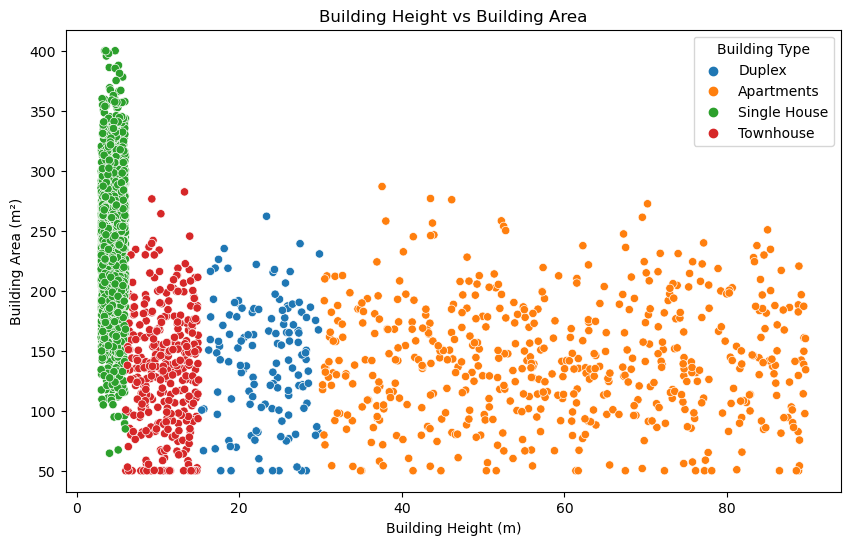

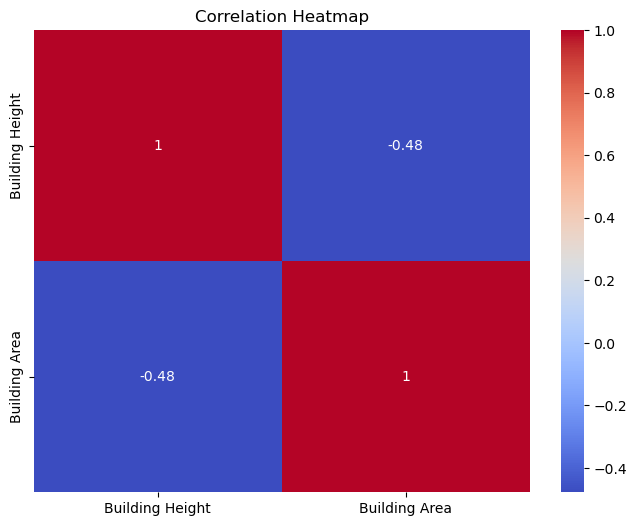

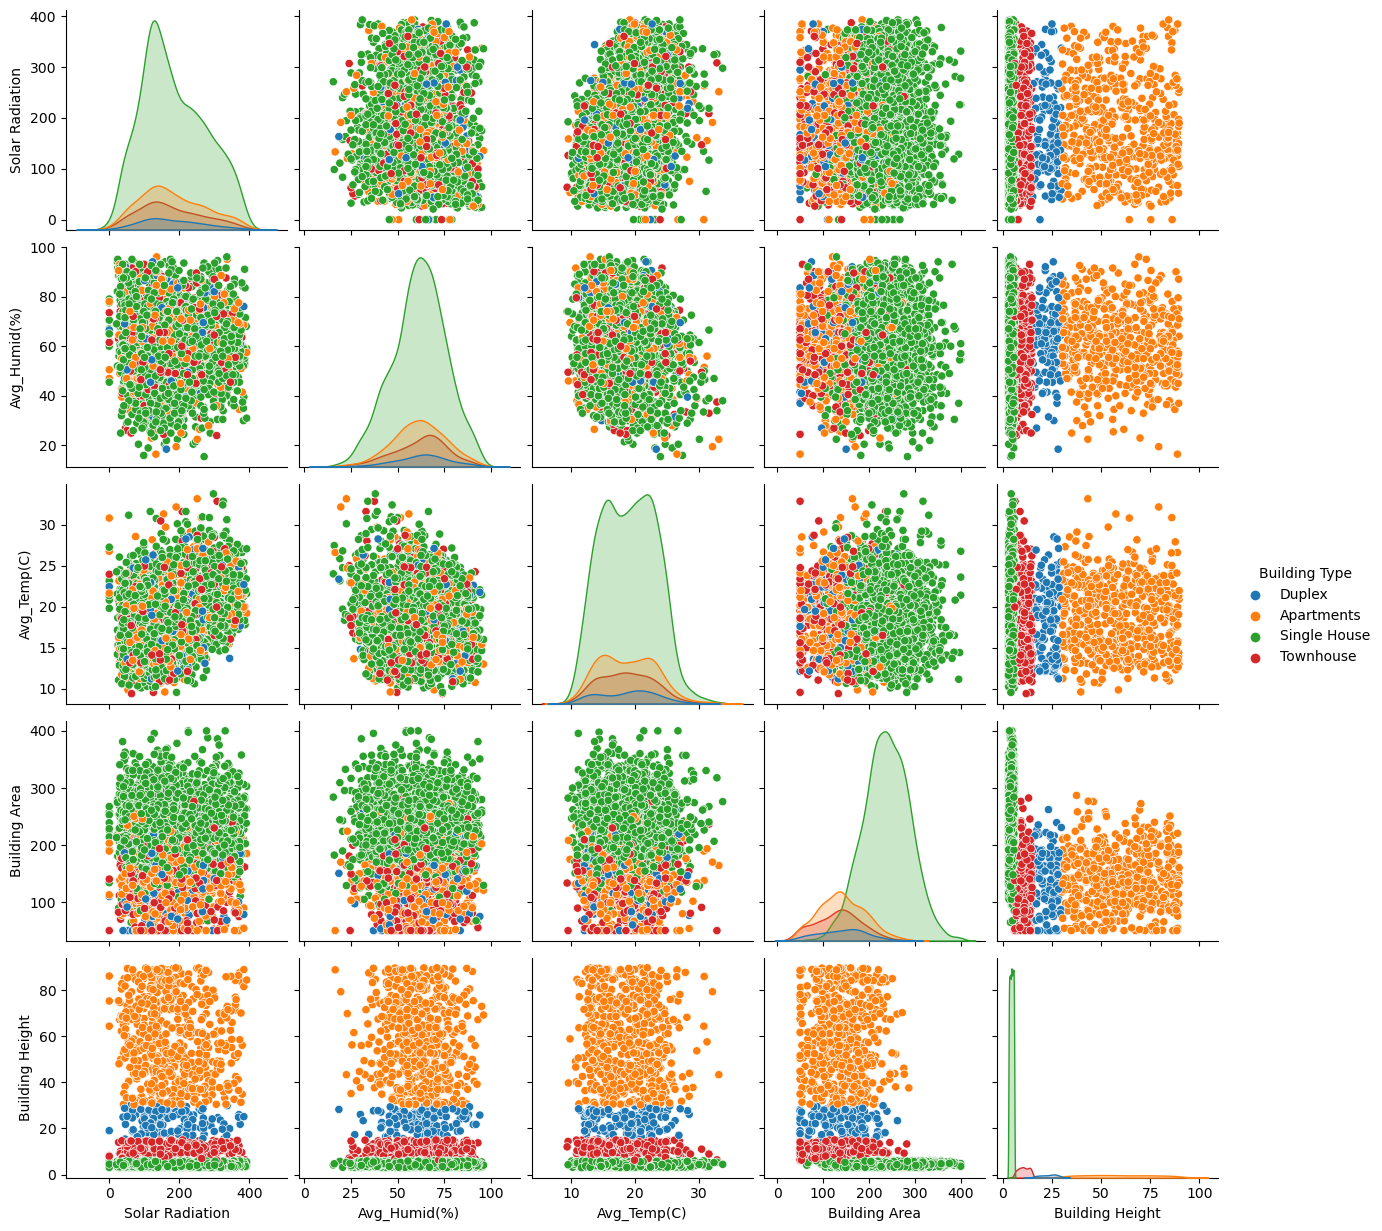

In [5]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Building Height', y='Building Area', hue='Building Type')
plt.title('Building Height vs Building Area')
plt.xlabel('Building Height (m)')
plt.ylabel('Building Area (m²)')
plt.show()
correlation_df = df[['Building Height', 'Building Area']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show
sns.pairplot(df, hue='Building Type')
plt.show()

In [6]:
def generate_power_consumption(row):
    base_value = 100  
    area_factor = row['Building Area'] / 100
    height_factor = row['Building Height'] / 10
    humid_factor = row['Avg_Humid(%)'] / 80
    temp_factor = row['Avg_Temp(C)'] / 35
    solar_factor = row['Solar Radiation'] / 1000
    
    power_consumption = base_value * (area_factor + height_factor + humid_factor + temp_factor + solar_factor)
    return np.random.normal(loc=power_consumption, scale=5)

df['Power Consumption'] = df.apply(generate_power_consumption, axis=1)
df

,Date,Solar Radiation,Avg_Humid(%),Avg_Temp(C),Building Area,Building Height,Building Type,Power Consumption
0,2008-02-01,75.231481,88.0,20.95,187.273496,25.934597,Duplex,628.615561
1,2008-02-02,192.129630,78.0,22.55,258.059243,38.023678,Apartments,826.917125
2,2008-02-03,107.638889,87.0,23.05,212.515195,5.722013,Single House,450.073414
3,2008-02-04,43.981481,86.5,21.50,224.002697,3.738866,Single House,432.726917
4,2008-02-05,98.379630,81.0,22.70,288.499519,3.486559,Single House,482.589015
...,...,...,...,...,...,...,...,...
3339,2017-06-21,121.527778,62.5,14.10,50.000000,14.072535,Townhouse,322.730800
3340,2017-06-22,143.518519,65.5,14.25,193.644989,14.457783,Townhouse,481.061334
3341,2017-06-23,231.481481,70.5,13.55,135.122991,63.780056,Apartments,930.012320
3342,2017-06-24,229.166667,45.5,14.70,173.573287,3.532020,Single House,330.358390


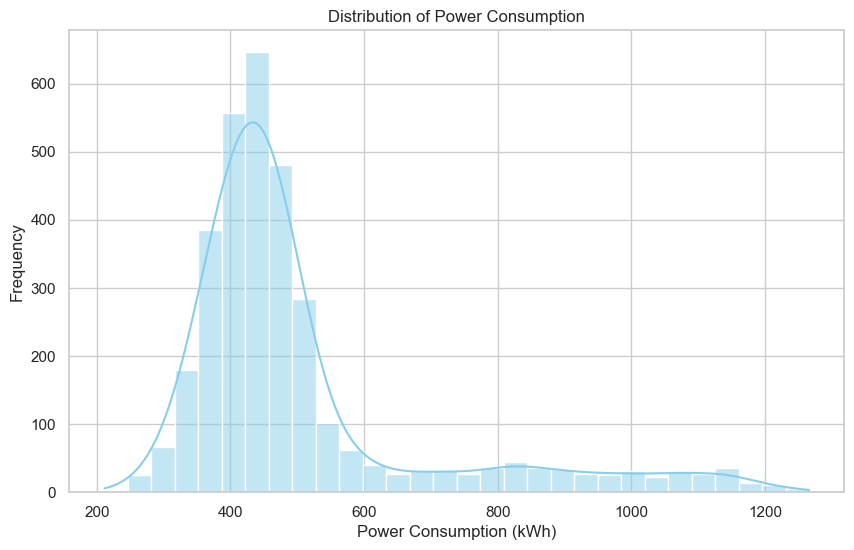

In [7]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(df['Power Consumption'], kde=True, color='skyblue', bins=30)
plt.title('Distribution of Power Consumption')
plt.xlabel('Power Consumption (kWh)')
plt.ylabel('Frequency')
plt.show()

The below codes can be used to generate data similar to above by CTGAN, but I have interrupted it as it was taking a lot of time in my device

In [8]:
perc = 1
Tr_fr = 0.50 
EPOCHS = 1000 
SAMPLES = 1000 
df = df.drop(columns=['Date'])
cull_df = df.sample(frac=perc).reset_index(drop=True)

train_data, test_data = train_test_split(cull_df, train_size=Tr_fr)

print(train_data.shape, test_data.shape)
try:
    features = ['Solar Radiation','Avg_Humid(%)','Avg_Temp(C)','Building Area','Building Height','Building Type']
    ctgan = CTGAN(verbose=True)
    ctgan.fit(train_data, features, epochs = EPOCHS)
    samples = ctgan.sample(SAMPLES)
    samples
except KeyboardInterrupt:
    print("Training interrupted by user")


(1672, 7) (1672, 7)


Gen. (0.00) | Discrim. (0.00):   0%|                                                          | 0/1000 [00:01<?, ?it/s]

Training interrupted by user


In [ ]:
def compare_summary_statistics(df, samples):
    summary_stats = pd.DataFrame({
        'Actual Mean': df.mean(),
        'Generated Mean': samples.mean(),
        'Actual Std': df.std(),
        'Generated Std': samples.std(),
        'Actual Min': df.min(),
        'Generated Min': samples.min(),
        'Actual Max': df.max(),
        'Generated Max': samples.max(),
    })
    return summary_stats

summary_stats = compare_summary_statistics(df, samples)
print(summary_stats)

In [ ]:
def compare_distributions(df, samples):
    for column in df.columns:
        plt.figure(figsize=(10, 6))
        sns.kdeplot(df[column], label='Actual', shade=True)
        sns.kdeplot(samples[column], label='Generated', shade=True)
        plt.title(f'Distribution Comparison for {column}')
        plt.legend()
        plt.show()

compare_distributions(df, samples)


In [ ]:
def compare_correlation_matrices(df, samples):
    actual_corr = df.corr()
    generated_corr = samples.corr()
    
    diff_corr = actual_corr - generated_corr

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    sns.heatmap(actual_corr, ax=axes[0], cmap='coolwarm', annot=True)
    axes[0].set_title('Actual Data Correlation Matrix')

    sns.heatmap(generated_corr, ax=axes[1], cmap='coolwarm', annot=True)
    axes[1].set_title('Generated Data Correlation Matrix')

    sns.heatmap(diff_corr, ax=axes[2], cmap='coolwarm', annot=True)
    axes[2].set_title('Difference in Correlation Matrices')

    plt.show()

compare_correlation_matrices(df, samples)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_pca_comparison(df, samples, n_components=2):
    pca = PCA(n_components=n_components)
    actual_pca = pca.fit_transform(df)
    generated_pca = pca.transform(samples)

    plt.figure(figsize=(10, 6))
    plt.scatter(actual_pca[:, 0], actual_pca[:, 1], label='Actual', alpha=0.5)
    plt.scatter(generated_pca[:, 0], generated_pca[:, 1], label='Generated', alpha=0.5)
    plt.title('PCA Comparison')
    plt.legend()
    plt.show()

def plot_tsne_comparison(df, samples, n_components=2):
    tsne = TSNE(n_components=n_components)
    actual_tsne = tsne.fit_transform(df)
    generated_tsne = tsne.fit_transform(samples)

    plt.figure(figsize=(10, 6))
    plt.scatter(actual_tsne[:, 0], actual_tsne[:, 1], label='Actual', alpha=0.5)
    plt.scatter(generated_tsne[:, 0], generated_tsne[:, 1], label='Generated', alpha=0.5)
    plt.title('t-SNE Comparison')
    plt.legend()
    plt.show()


plot_pca_comparison(df, samples)
plot_tsne_comparison(df, samples)


In [10]:
#generating 10000 sample data
mean_temp = 30   # in degrees Celsius
std_temp = 5

mean_humidity = 67  # in percentage
std_humidity = 15

mean_solar = 183  # in W/m²
std_solar = 90

# Number of data points to generate
num_samples = 10000

# Generate random data
temperature = np.random.normal(mean_temp, std_temp, num_samples)
humidity = np.random.normal(mean_humidity, std_humidity, num_samples)
solar_intensity = np.random.normal(mean_solar, std_solar, num_samples)

# Create a DataFrame to hold the data
data = pd.DataFrame({
    'Avg_Temp(C)': temperature,
    'Avg_Humid(%)': humidity,
    'Solar Radiation': solar_intensity
})

num_samples = 10000


proportions = {
    'Single House': 0.70,
    'Apartments': 0.16,
    'Townhouse': 0.10,
    'Duplex': 0.04
}


counts = {key: int(proportions[key] * num_samples) for key in proportions}

building_types = []
for building_type, count in counts.items():
    building_types.extend([building_type] * count)


if len(building_types) < num_samples:
    building_types.extend(['Single House'] * (num_samples - len(building_types)))


np.random.shuffle(building_types)

height_ranges = {
    'Single House': (3, 6),
    'Townhouse': (6, 15),
    'Duplex': (15, 30),
    'Apartments': (30, 90)
}


area_means = {
    'Single House': 239.4,
    'Townhouse': 137,
    'Duplex': 137,
    'Apartments': 137
}

building_heights = []
building_areas = []

for bt in building_types:
    height_min, height_max = height_ranges[bt]
    height = np.random.uniform(height_min, height_max)
    height = np.clip(height, height_min, height_max)  
    building_heights.append(height)
    area = np.random.normal(area_means[bt], 50)
    area = np.clip(area, 50, 400)
    building_areas.append(area)

data['Building Type']= building_types
data['Building Height']= building_heights
data['Building Area']= building_areas

print(data['Building Type'].value_counts(normalize=True))


average_heights = data.groupby('Building Type')['Building Height'].mean()

print(average_heights)
data['Power Consumption'] = data.apply(generate_power_consumption, axis=1)
data.to_csv('sydney_power_data.csv', index=False)
data

Single House    0.70
Apartments      0.16
Townhouse       0.10
Duplex          0.04
Name: Building Type, dtype: float64
Building Type
Apartments      60.088251
Duplex          22.414380
Single House     4.484224
Townhouse       10.421632
Name: Building Height, dtype: float64


,Avg_Temp(C),Avg_Humid(%),Solar Radiation,Building Type,Building Height,Building Area,Power Consumption
0,27.054112,65.585478,132.625320,Single House,5.394298,170.496646,401.918551
1,30.006958,82.712193,160.809654,Apartments,74.392310,60.054626,1015.578708
2,39.011644,50.234572,268.263986,Townhouse,11.667462,50.000000,371.136081
3,42.669228,49.564827,272.510149,Single House,4.191470,235.551462,488.372256
4,31.876683,54.936512,134.812886,Apartments,70.510637,144.060024,1026.569265
...,...,...,...,...,...,...,...
9995,36.538476,43.625583,336.387775,Single House,5.661874,210.743315,450.658678
9996,29.988144,20.513935,81.225285,Townhouse,6.160222,116.444096,295.776676
9997,29.541357,79.611701,221.271320,Duplex,17.092117,102.604995,488.770384
9998,37.678812,69.326210,68.602650,Single House,3.564183,297.371323,535.128837
